# Проект: Анализ бизнес-показателей

Я — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. После сделанных вложений, компания терпит убытки на протяжении нескольких месяцев. Нужно разобраться в причинах и помочь компании выйти в плюс.

# Описание данных

В распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.  
Структура visits_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.  

Структура orders_info_short.csv:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.  

Структура costs_info_short.csv:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

# План работы
**Шаг 1. Загрузка данных и подготовка к анализу  
Шаг 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии  
Шаг 3. Исследовательский анализ данных  
Шаг 4. Маркетинг  
Шаг 5. Оценка окупаемости рекламы** 

### Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def info_frames(*frames):
    for frame in frames:
        frame.info()
        print()
        print('\033[1m' + 'Количество дубликатов в таблице:' + '\033[0m', frame.duplicated().sum())
        print()       

In [3]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [4]:
info_frames(visits, orders, costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

Количество дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

Количество дубликатов в таблице: 0

<class 'pandas.core.frame.DataFrame'>
RangeInd

In [5]:
print('Список уникальных значений в столбце Region таблицы посещений:', list(visits['Region'].unique()), '\n')
print('Список уникальных значений в столбце Device таблицы посещений:', list(visits['Device'].unique()), '\n')
print('Список уникальных значений в столбце Channel таблицы посещений:', list(visits['Channel'].unique()), '\n')
print('Список уникальных значений в столбце Region таблицы расходов:', list(costs['Channel'].unique()))

Список уникальных значений в столбце Region таблицы посещений: ['United States', 'UK', 'France', 'Germany'] 

Список уникальных значений в столбце Device таблицы посещений: ['iPhone', 'Mac', 'Android', 'PC'] 

Список уникальных значений в столбце Channel таблицы посещений: ['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom', 'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner', 'OppleCreativeMedia', 'lambdaMediaAds'] 

Список уникальных значений в столбце Region таблицы расходов: ['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit', 'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner', 'lambdaMediaAds']


In [6]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower()
visits.session_start = pd.to_datetime(visits.session_start)
visits.session_end = pd.to_datetime(visits.session_end)
orders.event_dt = pd.to_datetime(orders.event_dt)
costs.dt = pd.to_datetime(costs.dt).dt.date

In [7]:
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942

**Вывод:** в данных нет ни пропусков, ни обычных и неявных дубликатов. Изменил тип данных в столбцах с датой и временем для дальнейшего удобства анализа. Привел названия столбцов к "змеиному" виду.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функции для вычисления значений метрик

In [8]:
def get_profiles(sessions, purchases, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = pd.to_datetime(profiles['first_ts'].dt.to_period('M').dt.to_timestamp().apply(lambda x: x.replace(day=1)))

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(purchases['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [9]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа 
    # тех, которые присоединились позже, чем observation_date - horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим «треугольную таблицу» 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к «треугольной» таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждую «ячейку» на соответствующий размер когорты и получаем retention rate
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # исключаем все лайфтаймы, превышающие горизонт анализа
        result['cohort_size'] = cohort_sizes                                                                     # восстанавливаем размеры когорт
        return result
    
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем обе таблицы и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped, result_in_time

In [10]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функции для построения графиков

In [12]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [13]:
def plot_retention(retention, retention_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Составление профилей пользователей

In [16]:
profiles = get_profiles(visits, orders, costs)
print(f'Минимальная дата привлечения пользователей: {profiles.dt.min()}\n\
Максимальная дата привлечения пользователей: {profiles.dt.max()}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


**Вывод:** пользователей привлекали с 1 мая по 27 октября 2019 года, что соответствует описанию.

#### Приход пользователей в разбивке по странам

In [17]:
def cat_profiles(category, sort = 'user_id'):
    display(
    profiles
    .groupby(category).agg({'user_id': 'count', 'payer': 'mean'})
    .sort_values(sort, ascending=False)
    .style.format({'payer': '{:.3f}'})
    )

In [18]:
cat_profiles('region')

,user_id,payer
region,,
United States,100002,0.069
UK,17575,0.040
France,17450,0.038
Germany,14981,0.041


**Вывод:** Больше всего пользователей привлекли из США, на них же приходится самая большая доля платящих пользователей. Из Великобритании и Франции примерно одинаковое число клиентов и доли платящих. Из Германии меньше всего пользователей, однако количество платящих пользоватлей выше, чем в Великобритании и Франции.

#### Приход пользователей в разбивке по устройствам

In [19]:
cat_profiles('device')

,user_id,payer
device,,
iPhone,54479,0.062
Android,35032,0.059
PC,30455,0.050
Mac,30042,0.064


**Вывод:** Больше всего пользователей было привлечено с iPhone, меньше всего с Mac. Хоть и число клиентов с Mac привлечено меньше всего, однако у них самая большая доля платящих. На последнем месте PC.

#### Приход пользователей в разбивке по каналам привлечения

In [20]:
cat_profiles('channel', sort = 'payer')

,user_id,payer
channel,,
FaceBoom,29144,0.122
AdNonSense,3880,0.113
lambdaMediaAds,2149,0.105
TipTop,19561,0.096
RocketSuperAds,4448,0.079
WahooNetBanner,8553,0.053
YRabbit,4312,0.038
MediaTornado,4364,0.036
LeapBob,8553,0.031


**Вывод:** Больше всего пользователей пришло самостоятельно, на последнем месте из источника lambdaMediaAds. По доля платящих пользователей на первом месте FaceBoom, на последнем пришедшие естественным образом. 

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [21]:
print(costs.costs.sum())
channel_costs = (
    costs.pivot_table(index='channel', values='costs', aggfunc='sum')
    .sort_values('costs', ascending=False)
    .reset_index()
)
channel_costs['Доля'] = round(channel_costs.costs / costs.costs.sum(), 3)
channel_costs.columns= ['Канал привлечения', 'Стоимость', 'Доля']
display(channel_costs)

105497.30000000002


,Канал привлечения,Стоимость,Доля
0,TipTop,54751.30,0.519
1,FaceBoom,32445.60,0.308
2,WahooNetBanner,5151.00,0.049
3,AdNonSense,3911.25,0.037
4,OppleCreativeMedia,2151.25,0.020
5,RocketSuperAds,1833.00,0.017
6,LeapBob,1797.60,0.017
7,lambdaMediaAds,1557.60,0.015
8,MediaTornado,954.48,0.009
9,YRabbit,944.22,0.009


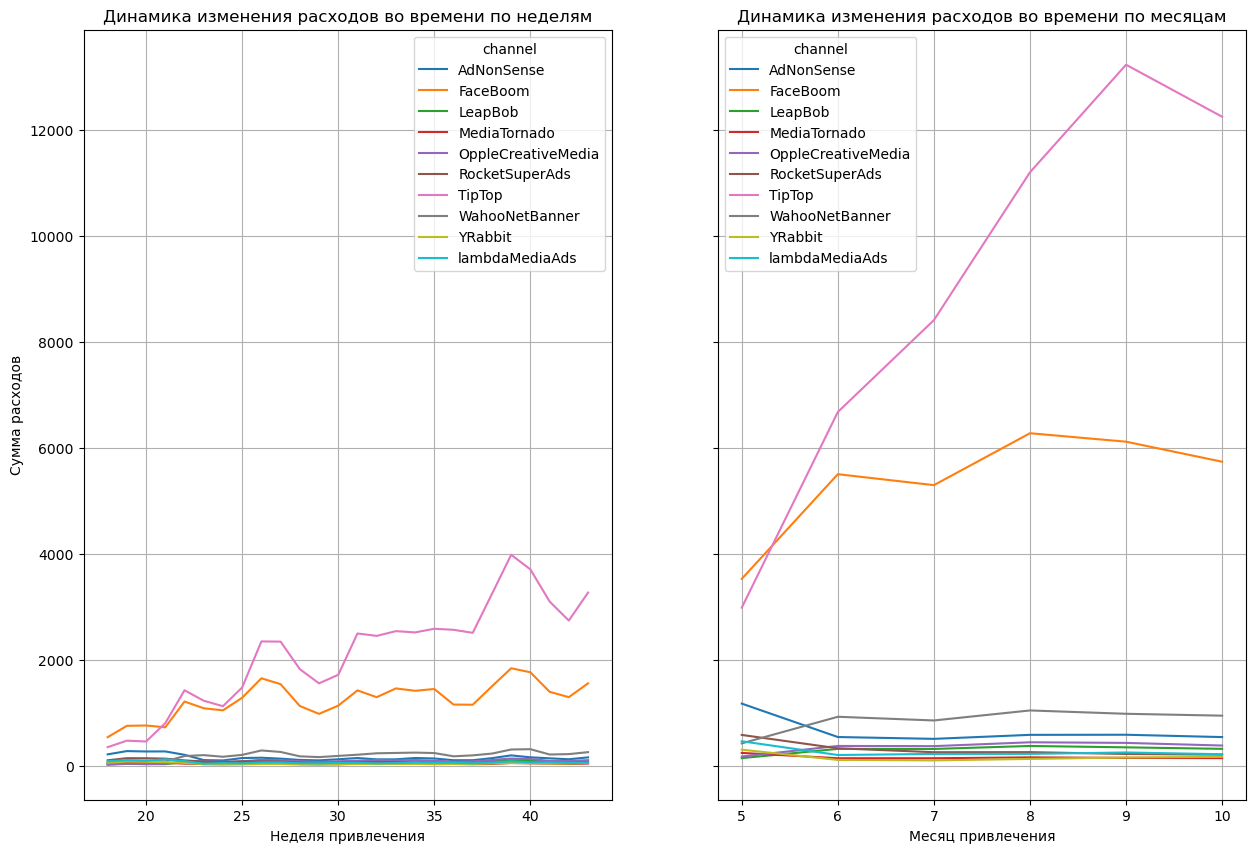

In [22]:
advanced_costs = costs.copy()
advanced_costs['week'] = pd.to_datetime(advanced_costs['dt']).dt.isocalendar().week
advanced_costs['month'] = pd.to_datetime(advanced_costs['dt']).dt.month
plt.figure(figsize=(15, 10));
ax1 = plt.subplot(1, 2, 1)
(
    advanced_costs
    .pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
    .plot(grid=True, ax=ax1)
);
plt.xlabel('Неделя привлечения');
plt.ylabel('Сумма расходов');
plt.title('Динамика изменения расходов во времени по неделям');
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
(
    advanced_costs
    .pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
    .plot(grid=True, ax=ax2)
);
plt.xlabel('Месяц привлечения');
plt.title('Динамика изменения расходов во времени по месяцам');

In [23]:
per_user = (
    profiles
    .pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
    .reset_index()
    .sort_values('acquisition_cost', ascending=False)
)
per_user.columns= ['Канал привлечения', 'Среедняя стоимость привлечения одного пользователя']
per_user.style.format({'Среедняя стоимость привлечения одного пользователя': '{:.2f}'})

,Канал привлечения,Среедняя стоимость привлечения одного пользователя
6,TipTop,2.80
1,FaceBoom,1.11
0,AdNonSense,1.01
9,lambdaMediaAds,0.72
7,WahooNetBanner,0.60
5,RocketSuperAds,0.41
4,OppleCreativeMedia,0.25
8,YRabbit,0.22
3,MediaTornado,0.22
2,LeapBob,0.21


**Вывод:** общая сумма расходов на маркетинг составила 105497. 2/3 из этой суммы ушло на каналы привлечения TipTop и Faceboom. На все, кроме двух рекламных источников, было потрачено, в динамике по неделям и месяцам, средств равномерно. Расходы на TipTop и FaceBoom в разбивке по неделям росли куда более заметно, нежели остальные, с просадками в некоторых неделях. В разбивке по месяцам на FaceBoom выделялись значительные средства до 9 месяца, на TipTop до 8, далее они пошли на незначительный спад. Самые большие затраты в пересчёте на пользователя уходили на TipTop и FaceBoom, однако стоимость привлечения пользоователя с канала AdNonSense приближенно равна FaceBoom.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Графики окупаемости рекламы для всех пользователей

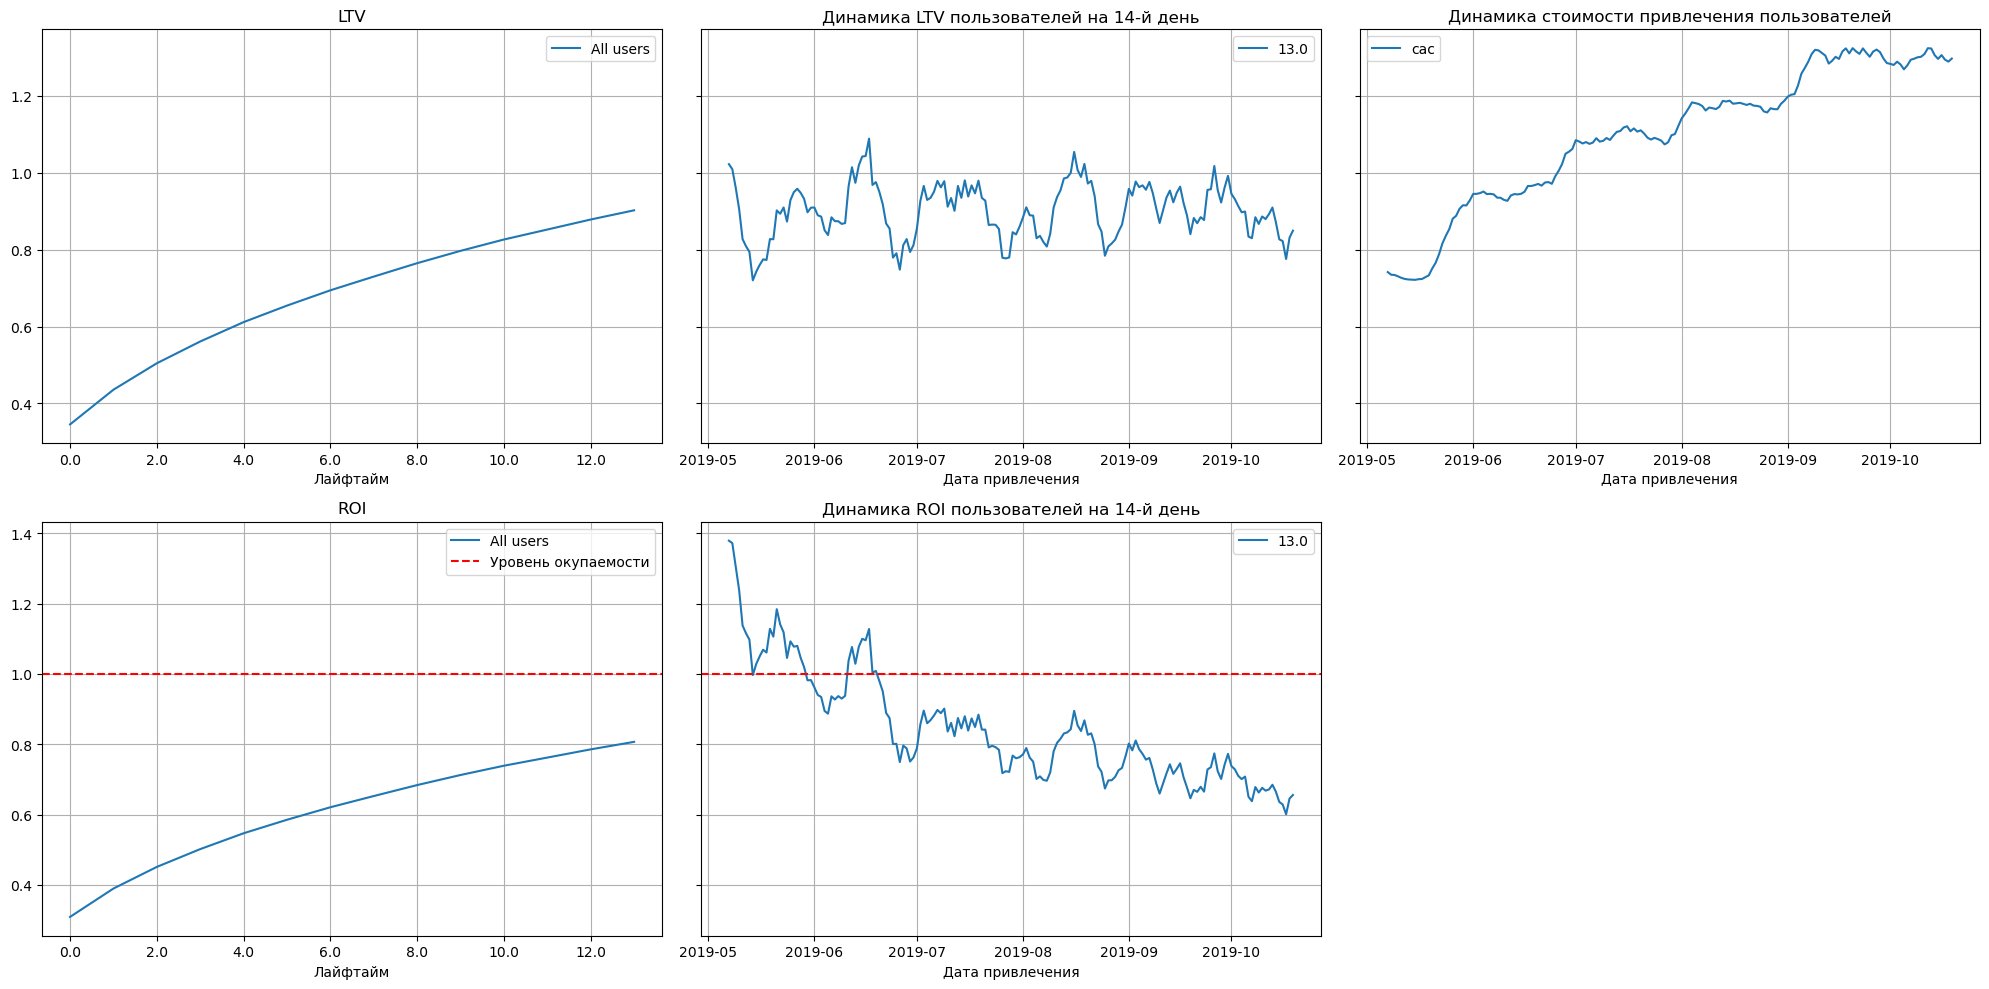

In [24]:
horizon_days = 14
observation_date = datetime(2019, 11, 1).date()
new_profiles = profiles.query('channel != "organic"')
raw_data, ltv, ltv_history, roi, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days)

**Вывод:** LTV растёт, как и ожидалось, в динамике 14-ого дня стабилен. CAC растёт с каждым месяцем. ROI в конце второй недели на уровне 80%, то есть реклама не отбивается, в динамике 14-ого дня окупаемость с каждым месяцем падает, но в течении каждого имеются увеличения, относительно начала, кроме последнего.

#### Графики удержания пользователей

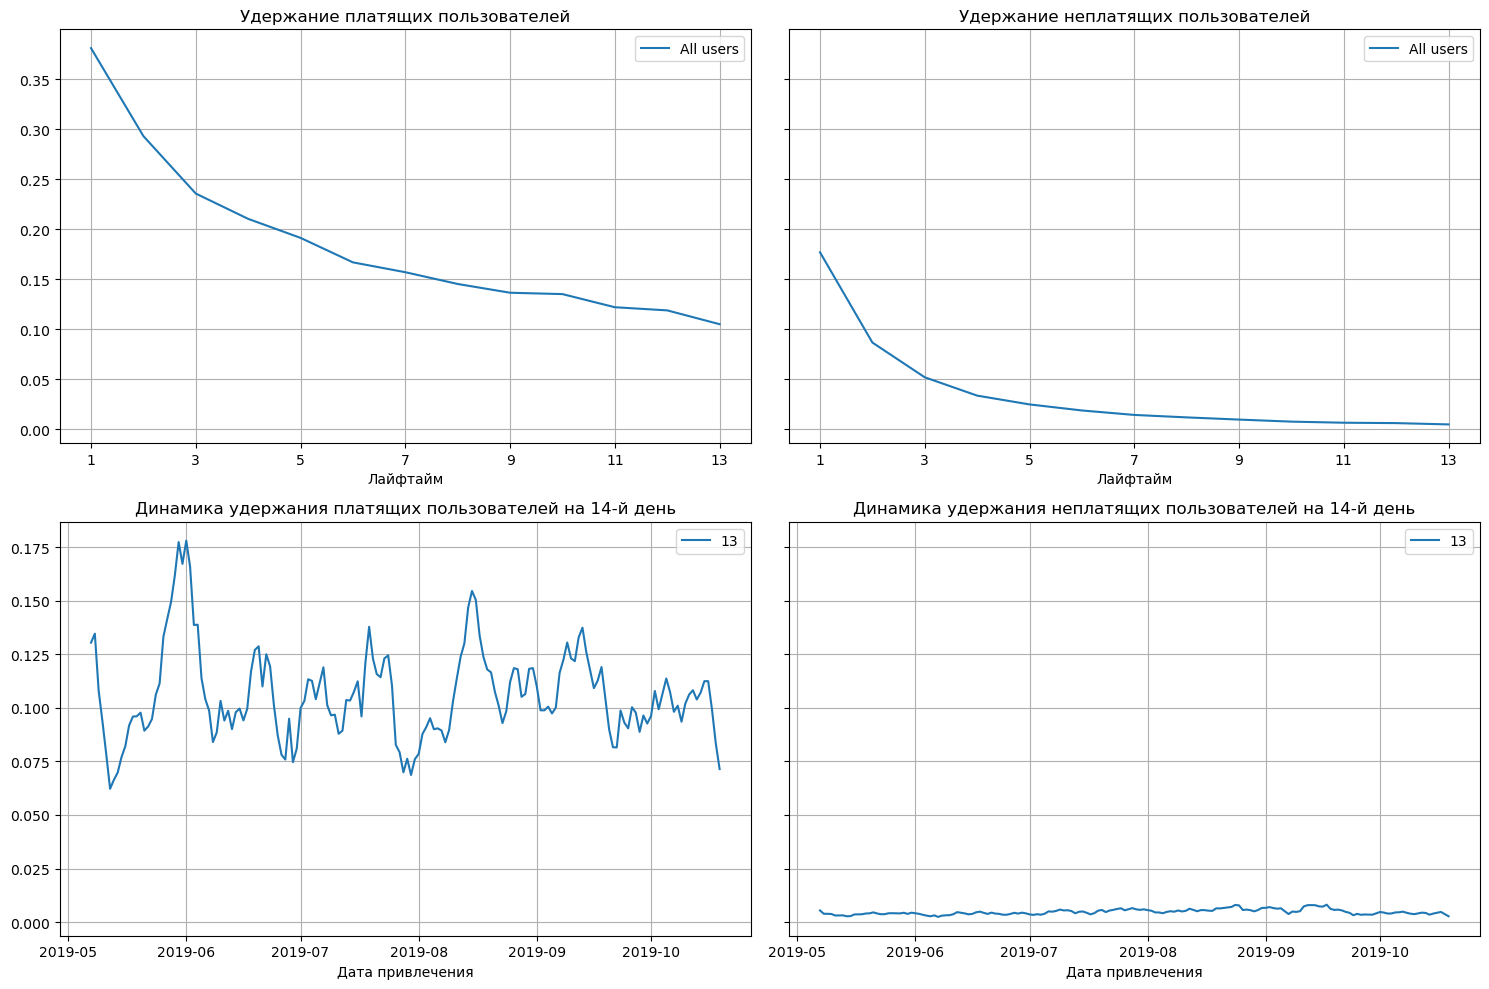

In [25]:
result_raw, retention, retention_history = get_retention(new_profiles, visits, observation_date, horizon_days)
plot_retention(retention, retention_history, horizon_days, 7)

**Вывод:** Кривая удержания платящих выше, чем не платящих. Обе кривые уходят вниз. В динамике всё стабильно.

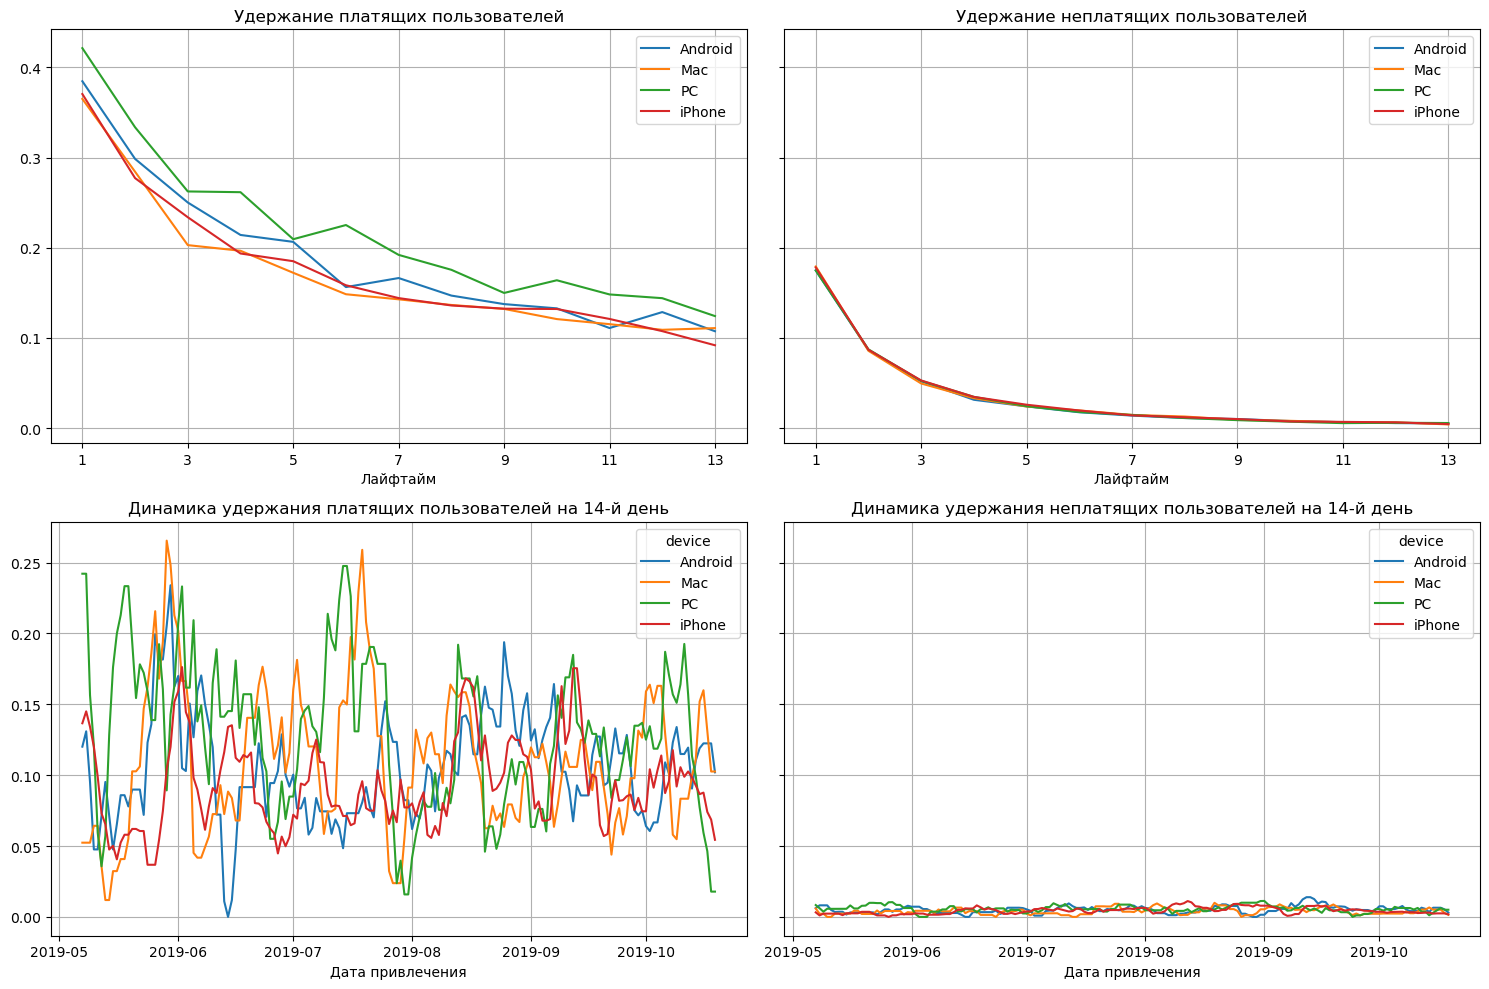

In [26]:
result_raw, retention_device, retention_history_device = get_retention(
    new_profiles, visits, observation_date, horizon_days, dimensions=['device'])
plot_retention(retention_device, retention_history_device, horizon_days, 7)

**Вывод:** Кривая удержания платящих выше, чем не платящих. Обе кривые уходят вниз. Пользователи Mac и iPhone удерживаются немногим хуже. В динамике всё стабильно.

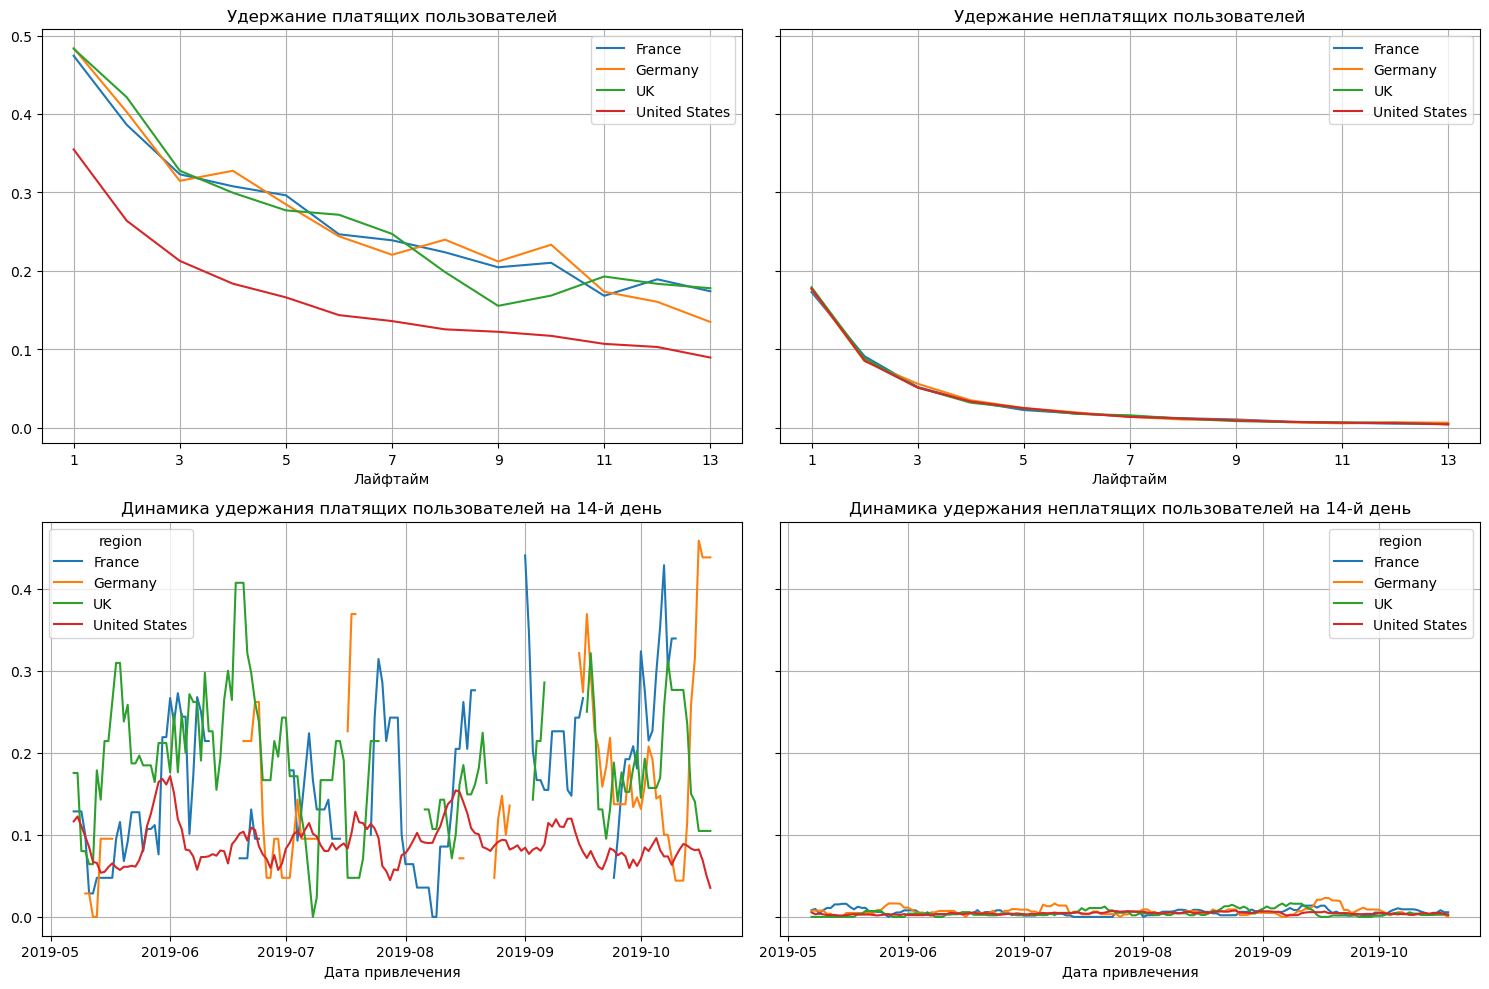

In [27]:
result_raw, retention_region, retention_history_region = get_retention(
    new_profiles, visits, observation_date, horizon_days, dimensions=['region'])
plot_retention(retention_region, retention_history_region, horizon_days, 7)

**Вывод:** Кривая удержания платящих выше, чем не платящих. Обе кривые уходят вниз. Пользователи из Америки удерживаются хуже. В динамике всё стабильно.

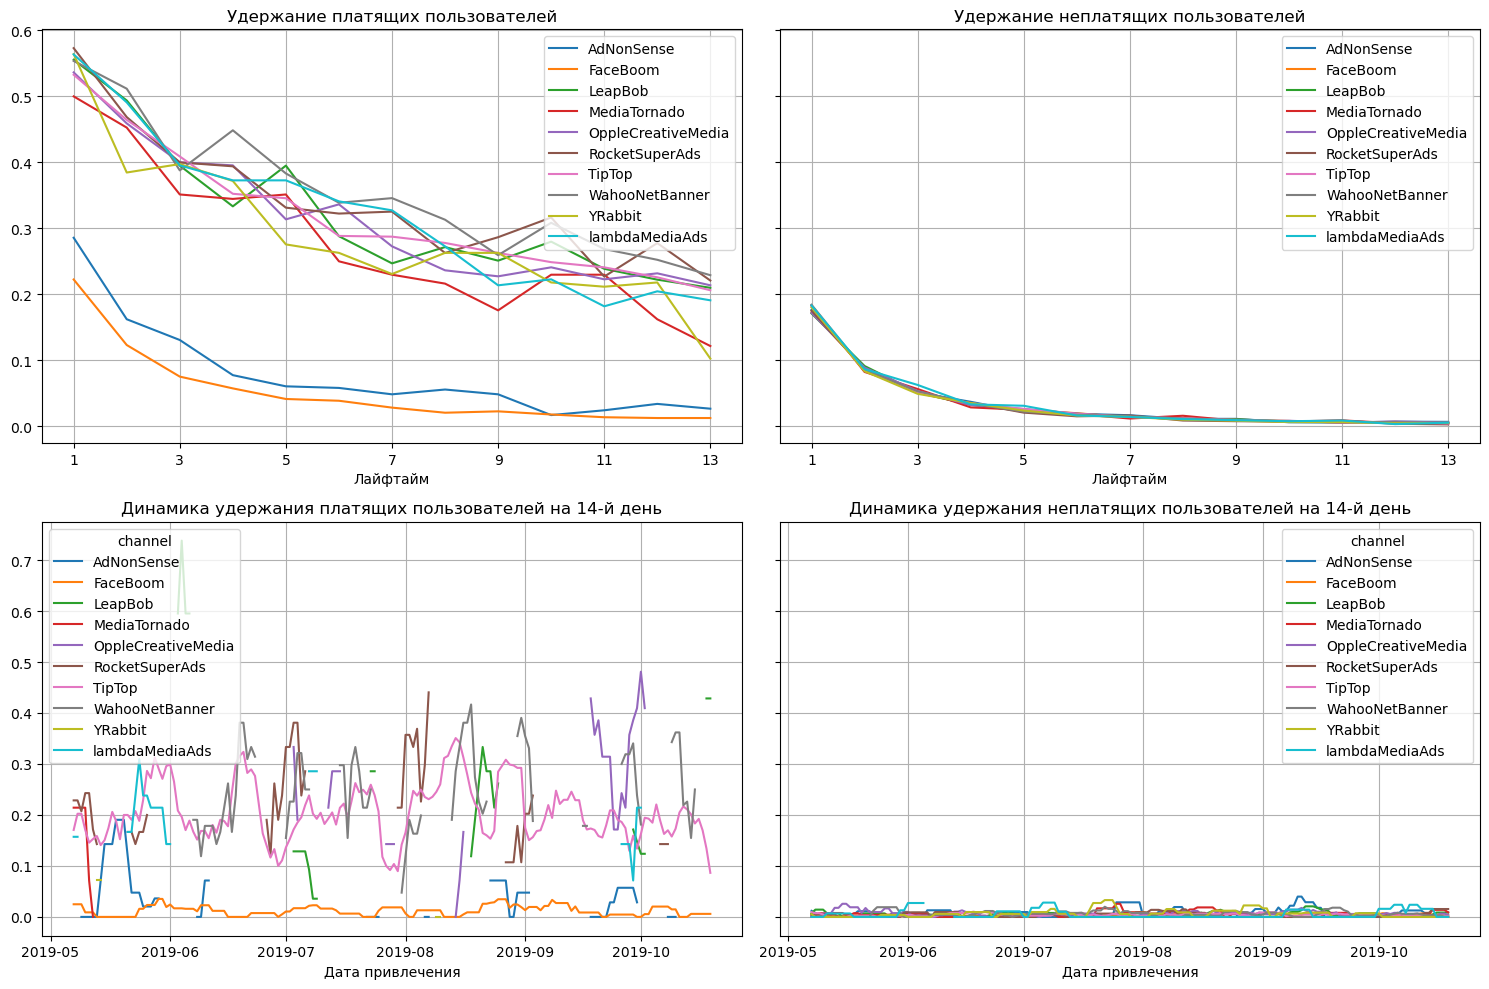

In [28]:
result_raw, retention_channel, retention_history_channel = get_retention(
    new_profiles, visits, observation_date, horizon_days, dimensions=['channel'])
plot_retention(retention_channel, retention_history_channel, horizon_days, 7)

**Вывод:** Кривая удержания платящих выше, чем не платящих, за исключением пользователей привлечённых из каналов FaceBoom и AdNonSense. Обе кривые уходят вниз. В динамике всё стабильно.

#### Графики конверсии пользователей

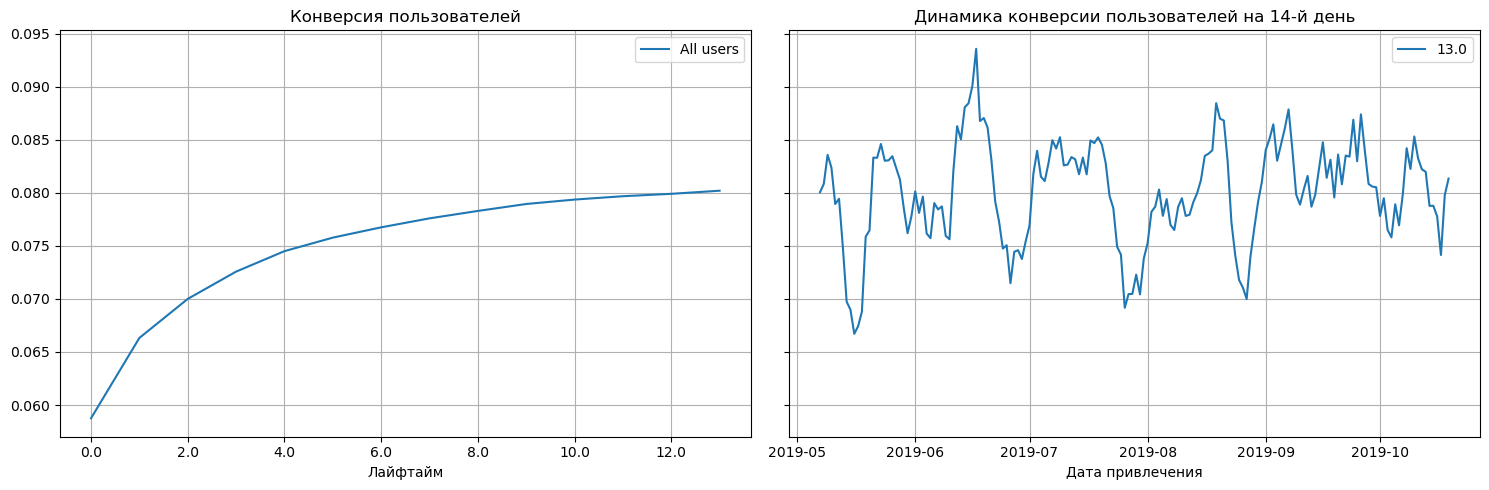

In [29]:
result_raw, conversion, conversion_history = get_conversion(new_profiles, orders, observation_date, horizon_days)
plot_conversion(conversion, conversion_history, horizon_days, 7)

**Вывод:** Кривая конверсии не падает, стремится к единице. В динамике всё стабильно.

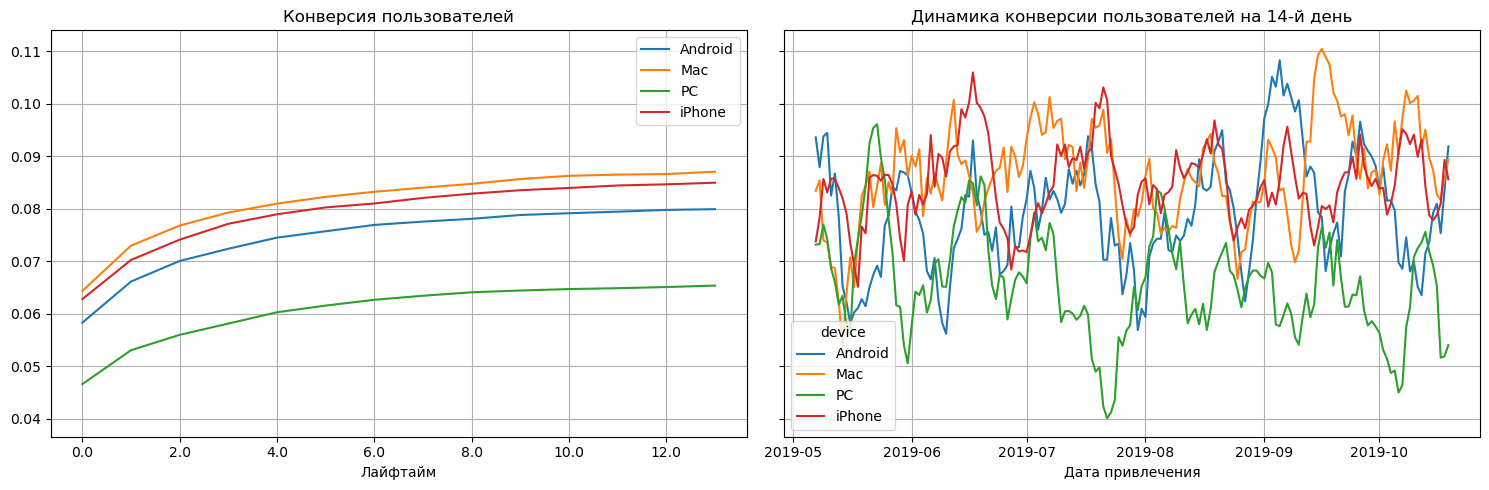

In [30]:
result_raw, conversion_device, conversion_history_device = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conversion_device, conversion_history_device, horizon_days, 7)

**Вывод:** Кривые конверсии не падают, стремятся к единице. В динамике всё стабильно. Пользователи iPhone хуже конвертируются, чем остальные.

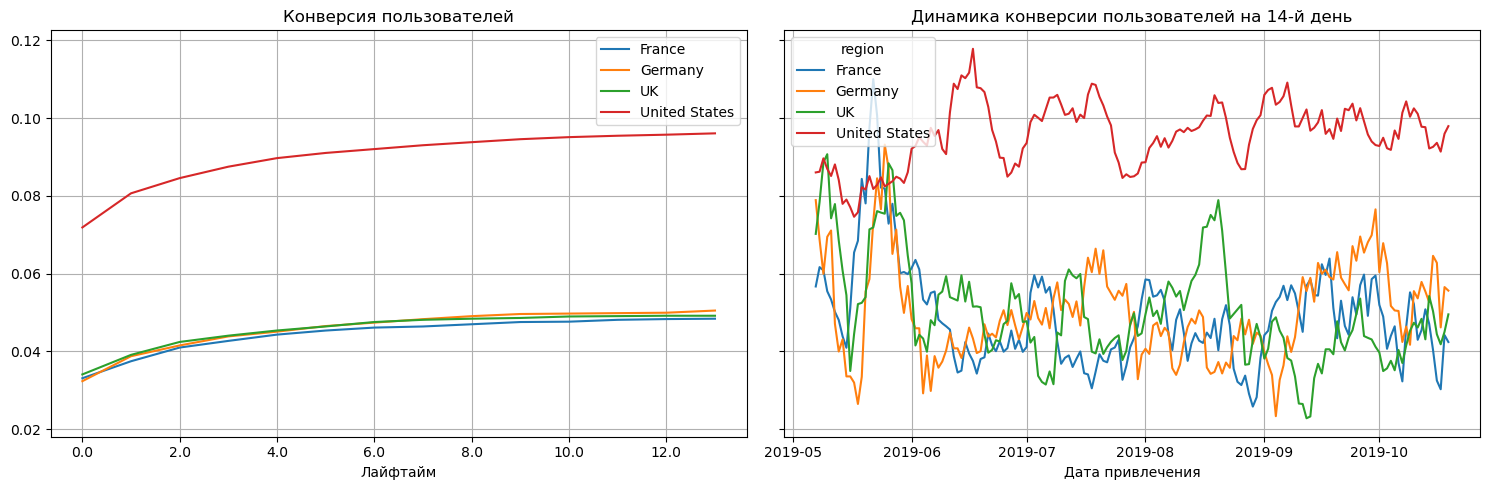

In [31]:
result_raw, conversion_region, conversion_history_region = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_conversion(conversion_region, conversion_history_region, horizon_days, 7)

**Вывод:** Кривые конверсии не падают, стремятся к единице. В динамике всё стабильно. Пользователи из Америки гораздо лучше остальных совершают покупки.

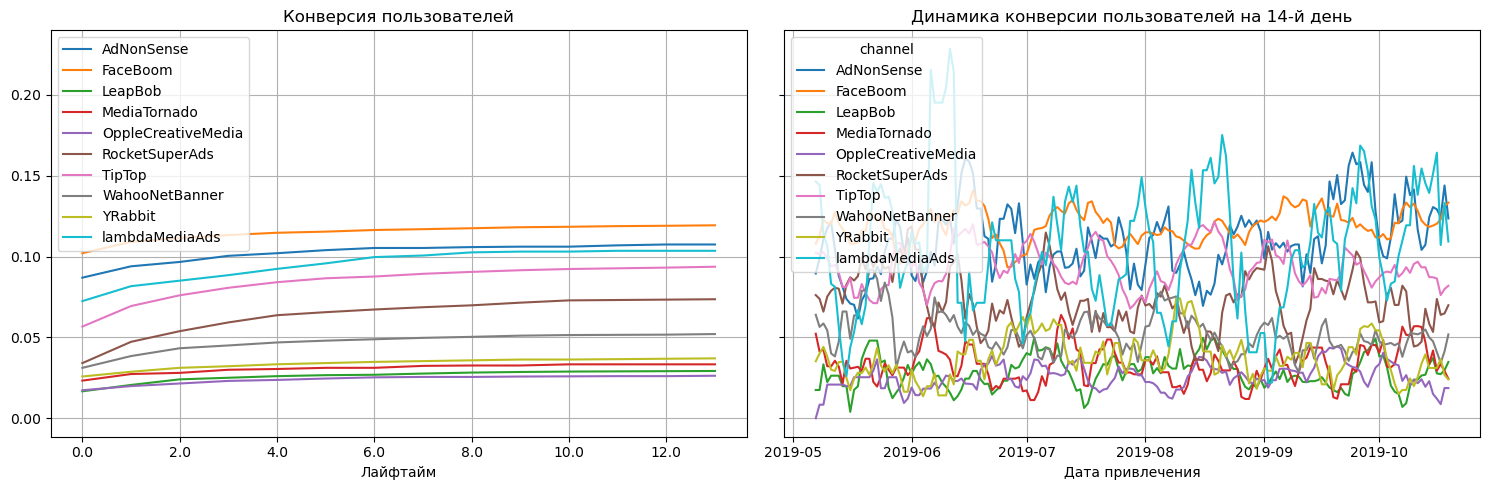

In [32]:
result_raw, conversion_channel, conversion_history_channel = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conversion_channel, conversion_history_channel, horizon_days, 7)

**Вывод:** Кривые конверсии не падают, стремятся к единице. В динамике всё стабильно.

#### Графики окупаемости в разбивке по устройствам

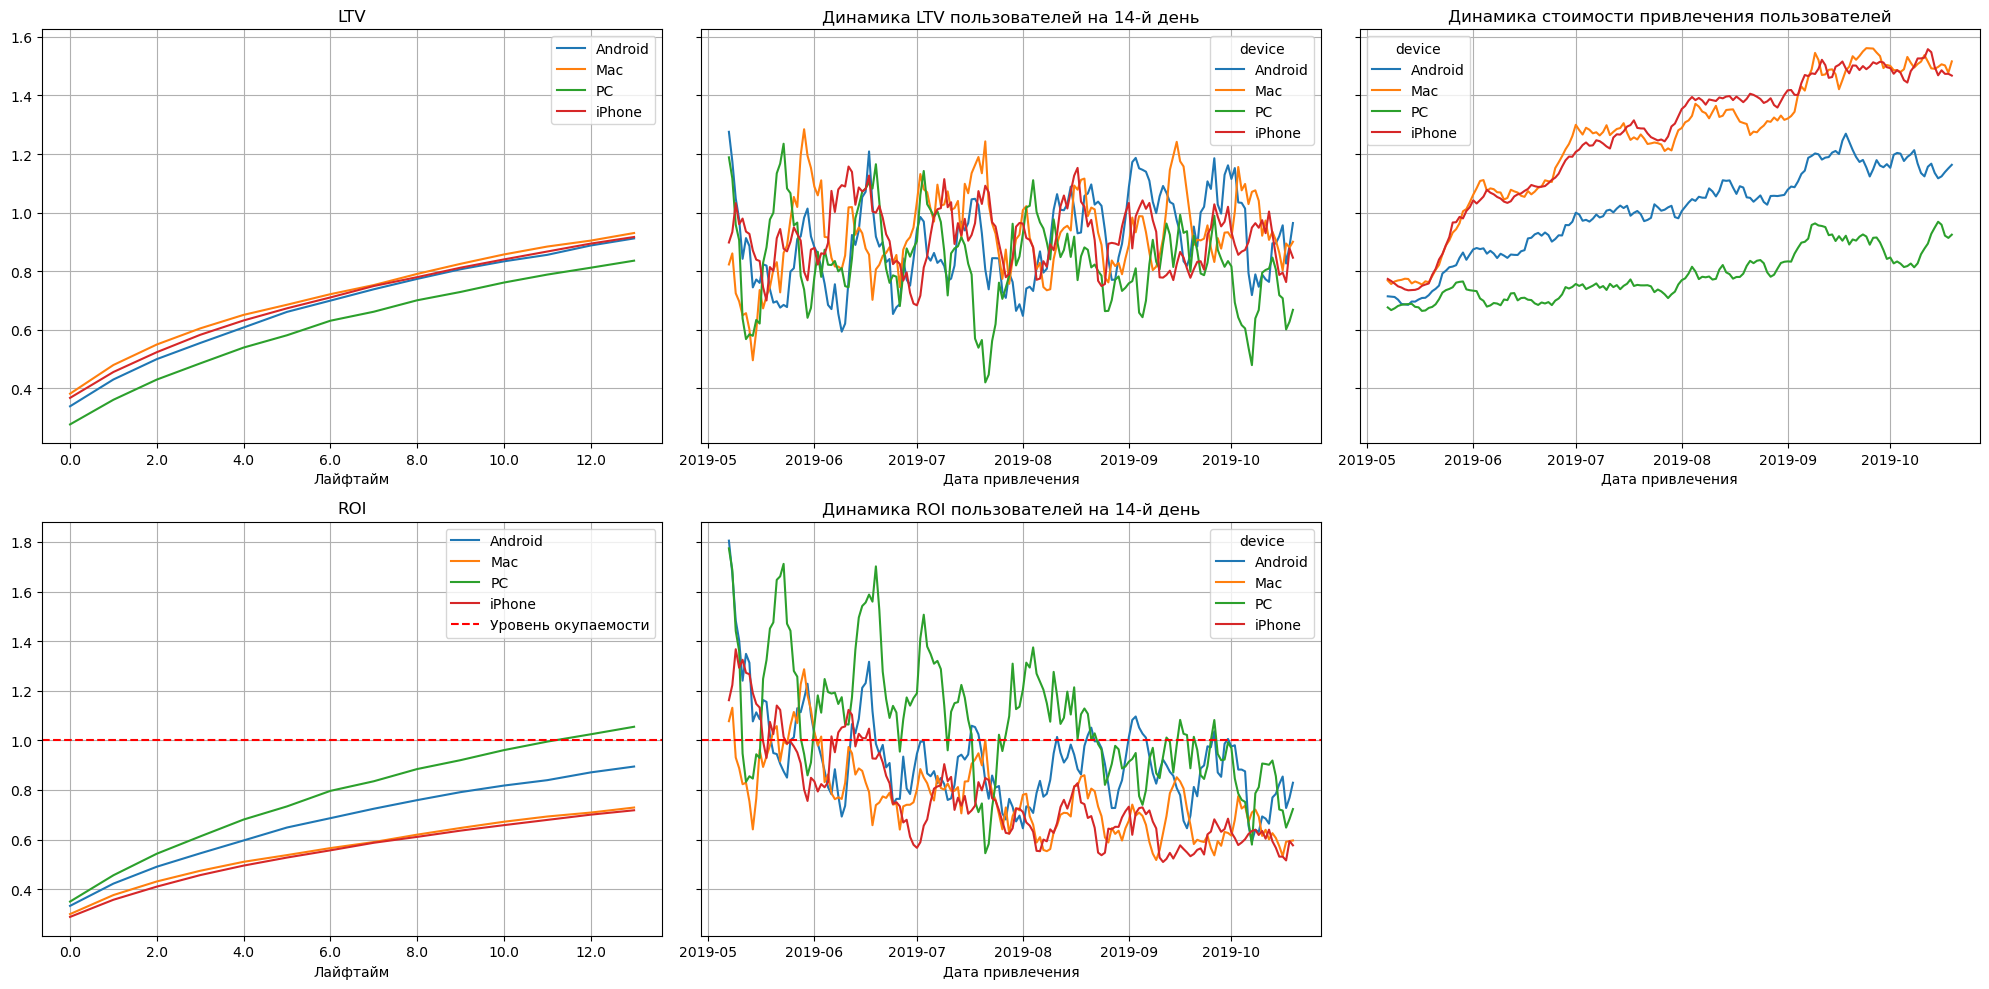

In [33]:
raw_data, ltv_device, ltv_history_device, roi_device, roi_history_device = (
    get_ltv(new_profiles, orders, observation_date, horizon_days, dimensions=['device'])
)
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days)

**Вывод:** "Пожизненная" стоимость клиентов PC ниже, чем у остальных. Стоимость привлечения пользователей с PC и Android дешевли, нежели с Mac и iPhone. Только на 11 день пользователи, привлечённых с PC, приносят больше, чем на них было затрачено. В динамике все клиенты перестали окупаться.

#### Графики окупаемости в разбивке по странам

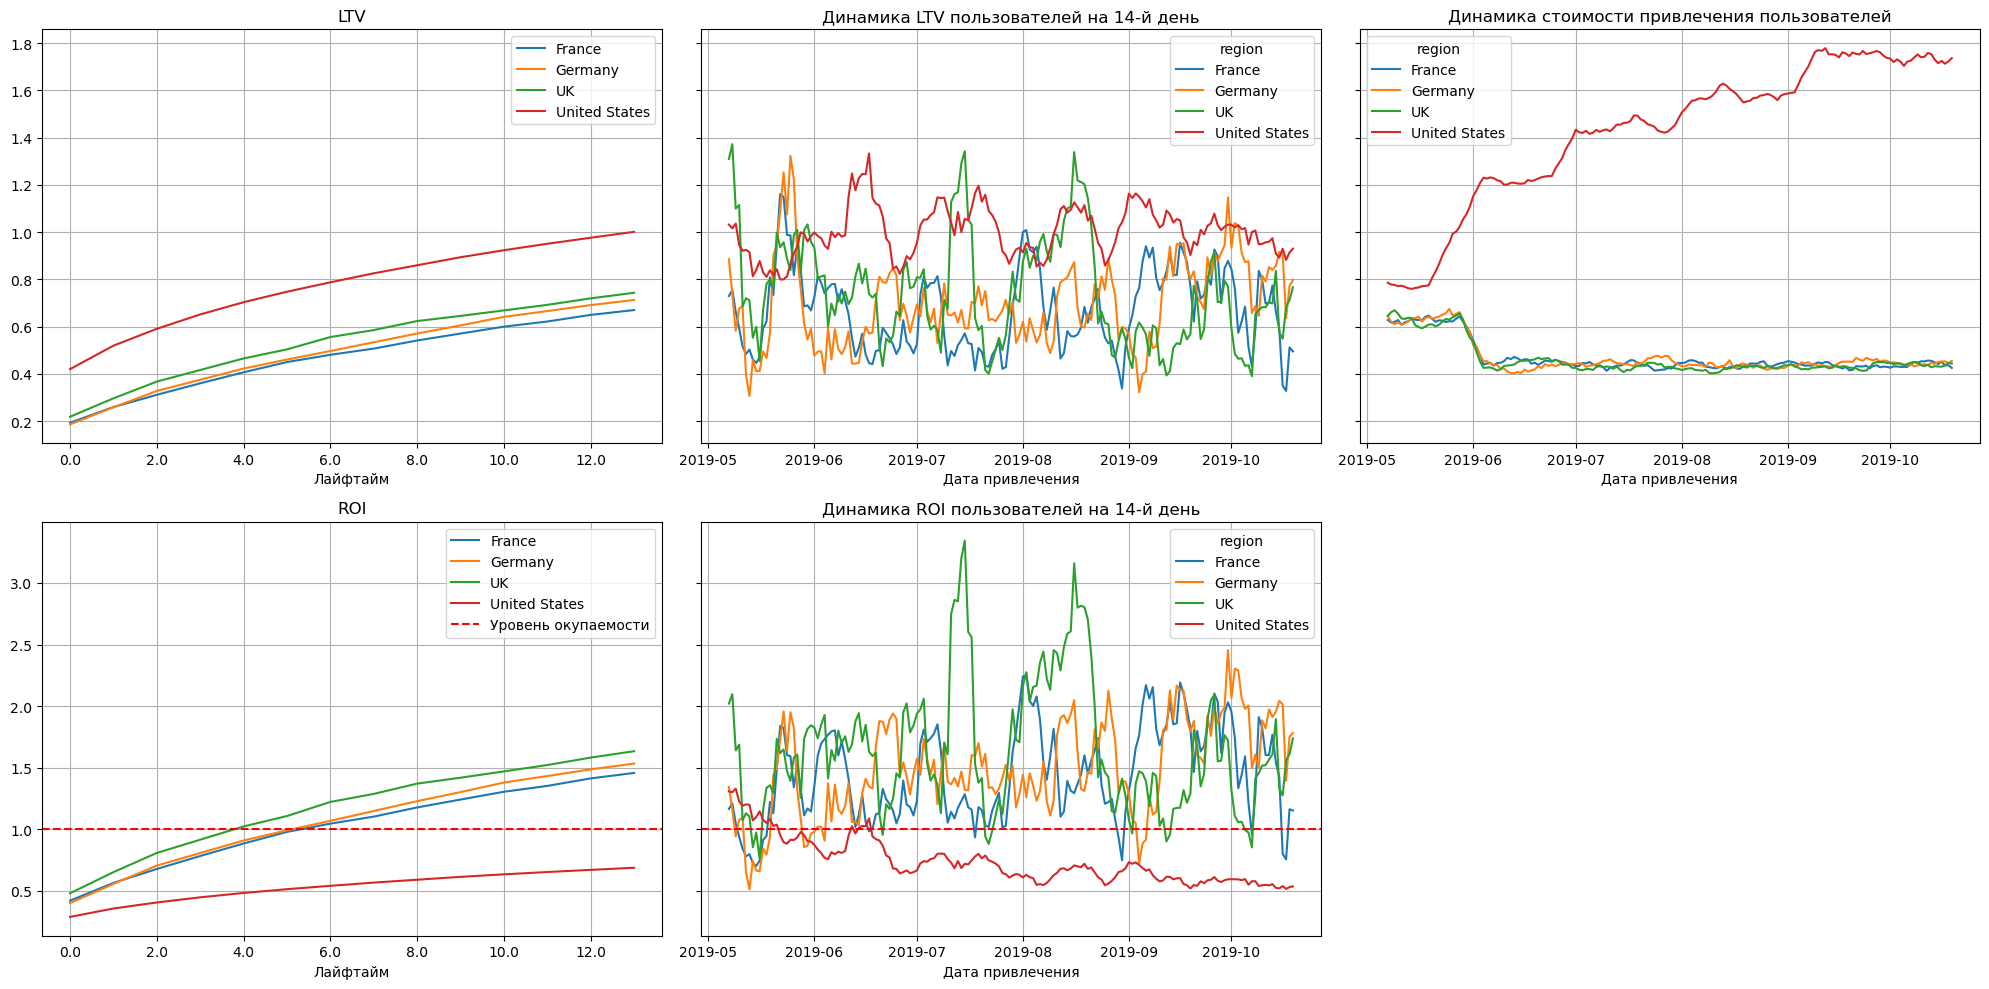

In [34]:
raw_data, ltv_region, ltv_history_region, roi_region, roi_history_region = (
    get_ltv(new_profiles, orders, observation_date, horizon_days, dimensions=['region'])
)
plot_ltv_roi(ltv_region, ltv_history_region, roi_region, roi_history_region, horizon_days)

**Вывод:** "Пожизненная" стоимость клиентов из Америки выше, чем у остальных. С мая по июнь наблюдается значительный рост расходов на привлечение из Америки, в свою очередь на другие страны выделяется меньше. Американские пользователи не окупаются, хотя с мая по июнь и с июня по июль заметен выход в плюс.

#### Графики окупаемости в разбивке по каналам привлечения

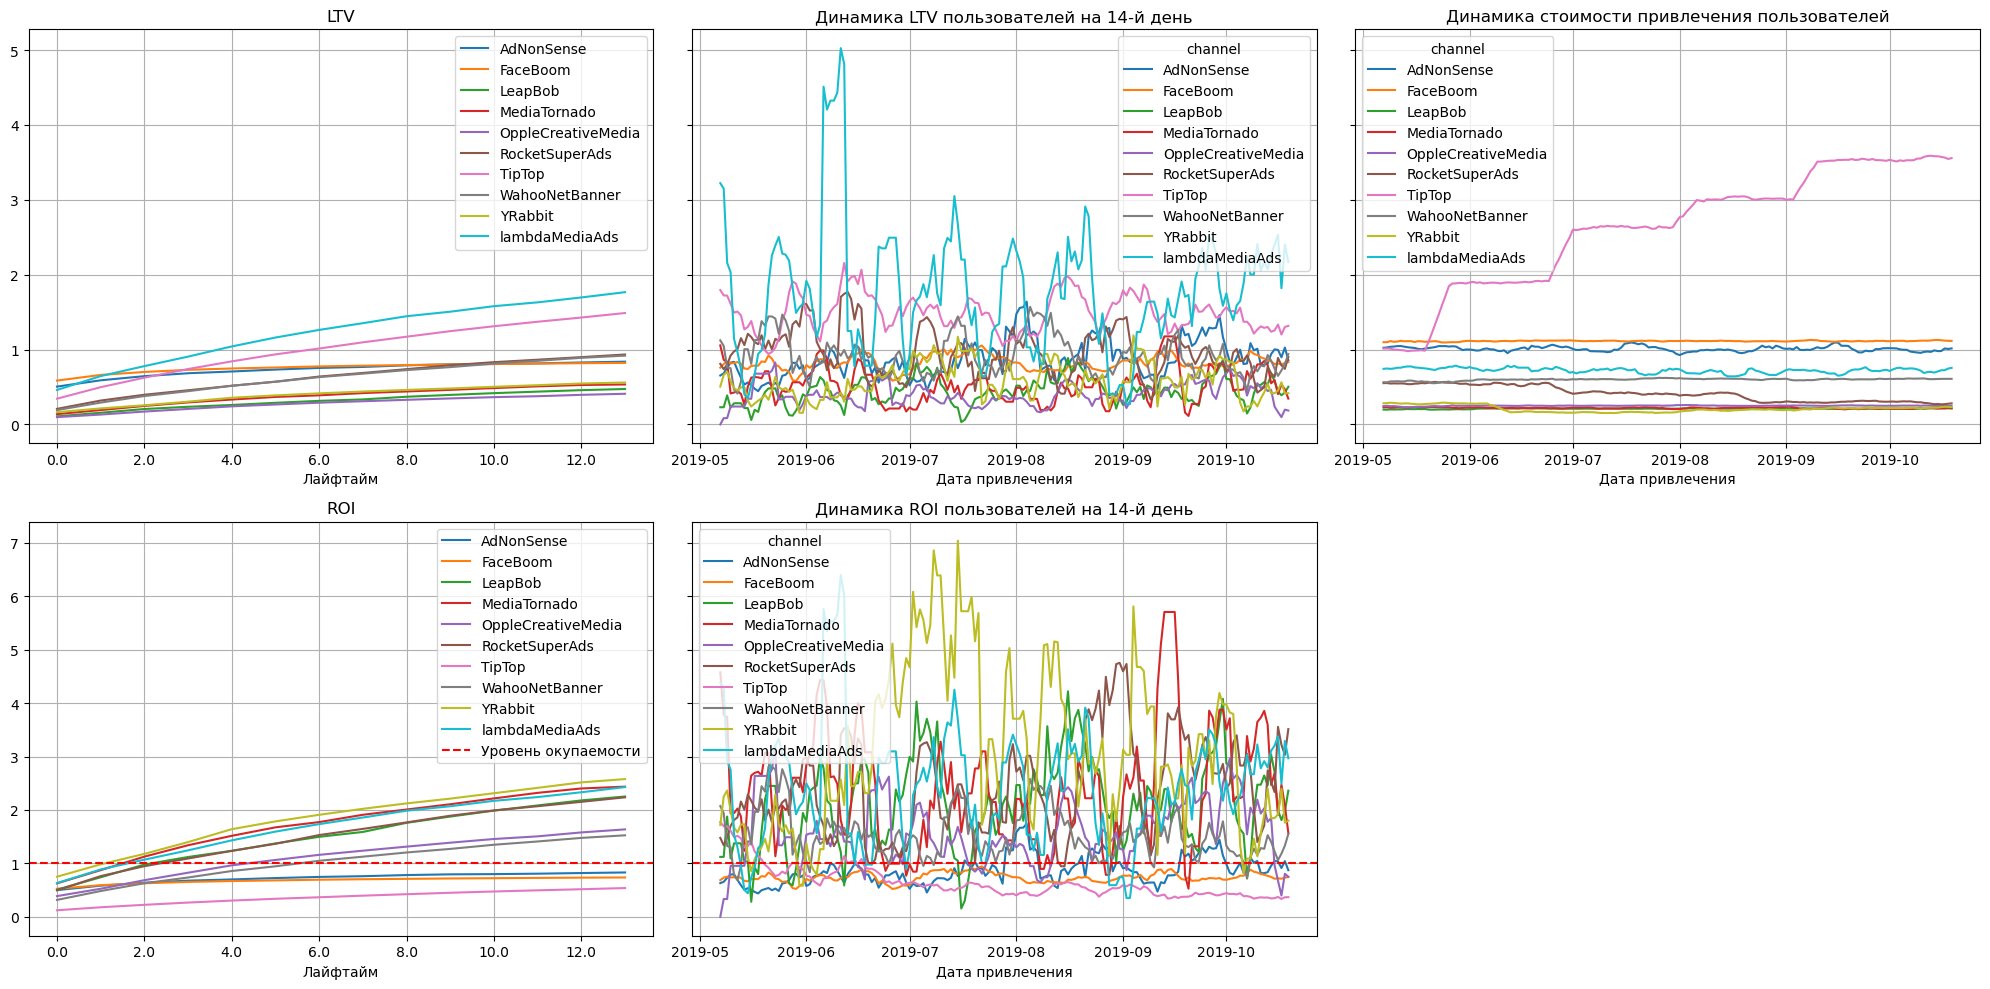

In [35]:
raw_data, ltv_channel, ltv_history_channel, roi_channel, roi_history_channel = (
    get_ltv(new_profiles, orders, observation_date, horizon_days, dimensions=['channel'])
)
plot_ltv_roi(ltv_channel, ltv_history_channel, roi_channel, roi_history_channel, horizon_days)

**Вывод:** "Пожизненная" стоимость клиентов привлечённых из AdNonSense и TipTop выше, чем у остальных. Динамика стоимости привлечения пользователей из TipTop росла с каждым месяц, на остальные каналы денег тратилось без изменений. TipTop, FaceBoom, AdNonSense не окупаются. В динамике только AdNonSense удаётся изредка выходить в плюс.

**Вывод:**
1. В целом реклама, направленная на привлечение пользователей не окупается. 
2. Негативные влияния на окупаемость рекламы оказывают устройства iPhone и Mac. Относительно стран, это Америка, также 3 канала привлечения: TipTop, FaceBoom, AdNonSense.
3. Проблемы с оккупаемостью могут быть связаны с возросшей стоимость привлечения клиентов.

На общем графике для всех пользователей наблюдается значительный рост трат на привлечения клиентов с конца мая, в связи с чем динамика окупаемости последнего дня падает с небольшими отскоками. Такая же ситуация в разбивке для устройств Mac и iPhone. Все вышесказанное связано с огромными вложениями в привлечение пользователей из Америки, относительно других стран. Также больше чем в три раза увеличились затраты на канал привлечения TipTop. Данные конверсии и удержания аномалий не содержат. Предлагаю сократить расходы на привлечения в некоторых областях.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

Не смотря на то, что больше всего пользователей пришло из Америки и на их долю приходится самая большая доля платящих пользоватлей, затраты на их привлечение не окупаются. Также они удерживаются куда хуже остальных. Клиенты, привлечённые из каналов FaceBoom и AdNonSense, удерживаются сильно хуже, однако занимают первые места по конверсии. Пользователи из канала TipTop обходятся компании дороже всего, хотя и занимают вторую строчку по числу привлечённых клиентов, тем не менее они с трудом окупаются даже в половину.   
Я считаю, что нужно оптимизировать расходы на превлечения и сместить фокус с канала TipTop, а также переориентировааться с каналов привлекающих людей из Амереки на равномерное привлечение пользоватлей из других стран. Рекомендую больше инвестировать в канал lambdaMediaAds. У него высокие показатели окупаемости со средними показателями на расходы. Хорошие коэффиценты конверсии и удержания.